In [16]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans

In [17]:

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("./../Intellivo-app/intellivo_package/intellivoUser.db")
# df1 = pd.read_sql_query("SELECT * from user_pref", con)
df1 = pd.read_csv("./dummy-user-pref-data.csv")
df2 = pd.read_sql_query("SELECT * from user", con)

# Verify that result of SQL query is stored in the dataframe
print(df1.head())
print(df2.head())

con.close()

   age  spirituality  location  engagement  user_id
0    1             1         1           1        4
1    1             3         6           4        6
2    3             2         4           3        7
3    3             2         8           4        8
4    4             3         3           2        9
   id firstname   lastname                email  \
0   3    hannah      ferns         hfer@whs.edu   
1   4   Chelsea  Fernandes  ccfernandes@scu.edu   
2   5   yvgubhi  yvgubhinj      vubhijn@uih.com   
3   6     Sejal        Dua   sejaldua@gmail.com   
4   7     Rahul        Dua  rahuldua1@gmail.com   

                                            password  
0  $2b$12$.8/w4iM2Rm5ju/bMOkdBVuqMrdQ5JU9CH/SpW5c...  
1  $2b$12$w.ZMUx6qFYlO35u2kv1kr.Lg4DL6n1qpJue5/xr...  
2  $2b$12$jYxC85uVoxjAK4hLsihiVOGN86eedebqWV53kxd...  
3  $2b$12$nzSYkzBuj824tBP7wYj1wOESu.D/UsK92/Uo8Lk...  
4  $2b$12$QLiq1tHvdpJP.MMhnvfyo.ymZSokDlXWSayeAdY...  


In [18]:
print(df1.head())
print(len(df1))

   age  spirituality  location  engagement  user_id
0    1             1         1           1        4
1    1             3         6           4        6
2    3             2         4           3        7
3    3             2         8           4        8
4    4             3         3           2        9
393


In [19]:
# data = df1.drop(columns=['user_id'])
# kmeans = KMeans(n_clusters=4)
# kmeans.fit(data)
# print(kmeans.cluster_centers_)
# df1['CLUSTER'] = kmeans.fit_predict(data)
# df1.tail()

In [20]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df1.drop(columns=['user_id']))

In [21]:
pca = PCA()
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

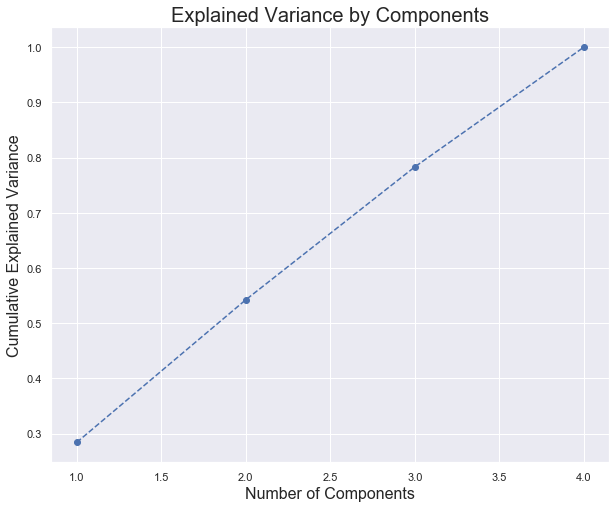

In [22]:
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components', fontsize=20)
plt.xlabel('Number of Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)
fig.savefig('explained-variance-components.png')

In [23]:
pca = PCA(n_components=3)
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
scores_pca = pca.transform(segmentation_std)

In [25]:
#WCSS = Within Cluster Sum of Squares
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

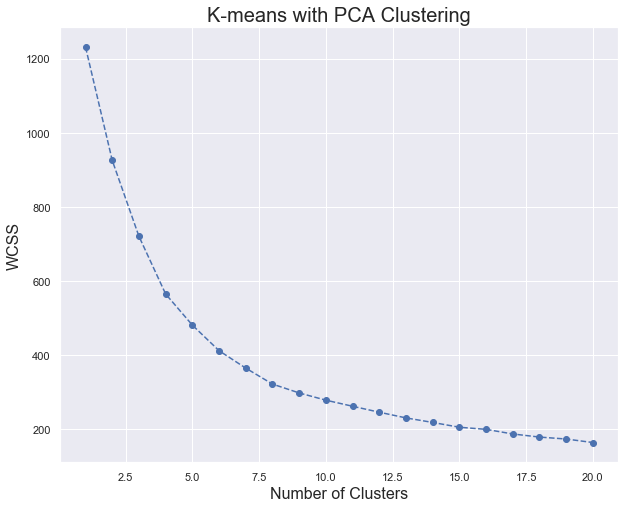

In [27]:
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA Clustering', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('WCSS', fontsize=16)
fig.savefig('number-of-clusters.png')

In [28]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [29]:
df_segm_pca_kmeans = pd.concat([df1.reset_index(drop = True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmeans['Cluster Labels'] = kmeans_pca.labels_
df_segm_pca_kmeans

,age,spirituality,location,engagement,user_id,Component 1,Component 2,Component 3,Cluster Labels
0,1,1,1,1,4,-2.835988,-0.521379,0.194094,3
1,1,3,6,4,6,-0.434348,-1.156306,-1.041635,0
2,3,2,4,3,7,-0.670458,0.064360,0.584068,3
3,3,2,8,4,8,0.365993,-0.473926,0.629211,1
4,4,3,3,2,9,-0.654515,1.431437,0.638769,3
...,...,...,...,...,...,...,...,...,...
388,2,1,8,5,440,0.186876,-1.806887,0.534125,0
389,2,2,7,5,441,0.240954,-1.402213,-0.050493,0
390,3,1,15,1,442,0.139686,0.122157,1.805331,1
391,3,1,10,2,443,-0.292425,-0.109078,1.487008,1


In [30]:
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Cluster Labels'].map({0: 'first',
                                                                        1: 'second',
                                                                        2: 'third',
                                                                        3: 'fourth'})

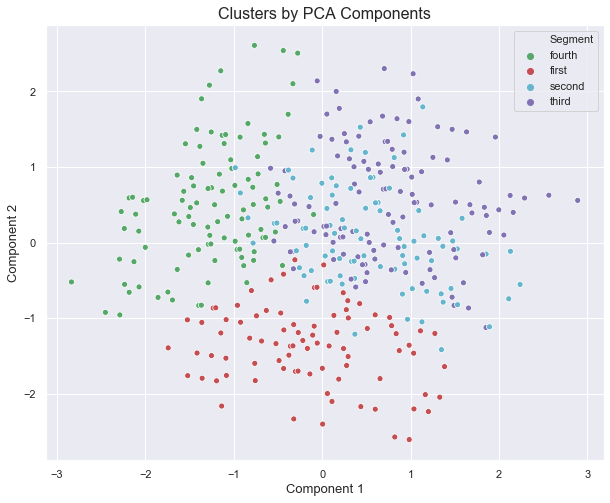

In [34]:
x_axis = df_segm_pca_kmeans['Component 1']
y_axis = df_segm_pca_kmeans['Component 2']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components', fontsize=16)
plt.ylabel('Component 2', fontsize=13)
plt.xlabel('Component 1', fontsize=13)
fig.savefig('clusters.png')

In [35]:
df_segm_pca_kmeans

,age,spirituality,location,engagement,user_id,Component 1,Component 2,Component 3,Cluster Labels,Segment
0,1,1,1,1,4,-2.835988,-0.521379,0.194094,3,fourth
1,1,3,6,4,6,-0.434348,-1.156306,-1.041635,0,first
2,3,2,4,3,7,-0.670458,0.064360,0.584068,3,fourth
3,3,2,8,4,8,0.365993,-0.473926,0.629211,1,second
4,4,3,3,2,9,-0.654515,1.431437,0.638769,3,fourth
...,...,...,...,...,...,...,...,...,...,...
388,2,1,8,5,440,0.186876,-1.806887,0.534125,0,first
389,2,2,7,5,441,0.240954,-1.402213,-0.050493,0,first
390,3,1,15,1,442,0.139686,0.122157,1.805331,1,second
391,3,1,10,2,443,-0.292425,-0.109078,1.487008,1,second


In [36]:
test_user = df_segm_pca_kmeans.iloc[1, :4]
credentials = df2[df2['id'] == df_segm_pca_kmeans.iloc[1, 4]]
cluster = df_segm_pca_kmeans.iloc[1, 8]
print("First Name\t\t", credentials.iloc[0, 1])
print("Last Name\t\t", credentials.iloc[0, 2])
print("Email\t\t\t", credentials.iloc[0, 3])
print("-------------------------------------------")
print("Age\t\t\t", test_user.iloc[0])
print("Spirituality\t\t", test_user.iloc[1])
print("Location\t\t", test_user.iloc[2])
print("Engagement\t\t", test_user.iloc[3])
print("-------------------------------------------")
print("Cluster\t\t\t", cluster)

First Name		 Sejal
Last Name		 Dua
Email			 sejaldua@gmail.com
-------------------------------------------
Age			 1
Spirituality		 3
Location		 6
Engagement		 4
-------------------------------------------
Cluster			 0


In [41]:
group = df_segm_pca_kmeans[df_segm_pca_kmeans["Cluster Labels"] == 2]
distances = []
for i in range(len(group)):
    distances.append(cosine(test_user, group.iloc[i, :4]))
group['distances'] = distances
group.sort_values(by='distances', ascending=False, inplace=True)
group

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,age,spirituality,location,engagement,user_id,Component 1,Component 2,Component 3,Cluster Labels,Segment,distances
327,3,4,1,5,373,0.042037,0.104185,-0.858346,2,third,0.254644
143,3,4,2,5,154,0.205211,0.070069,-0.817961,2,third,0.212274
292,4,5,4,2,327,-0.056839,2.138434,-0.409310,2,third,0.200000
318,2,5,2,4,363,-0.306917,0.281859,-1.768718,2,third,0.180108
191,4,5,3,5,207,0.931258,0.967094,-0.798886,2,third,0.147987
...,...,...,...,...,...,...,...,...,...,...,...
264,3,5,11,5,293,1.891024,0.133575,-0.998727,2,third,-0.000740
287,3,3,8,4,320,0.583244,-0.103369,0.084979,2,third,-0.001388
253,2,4,5,3,280,-0.418404,0.210771,-0.986934,2,third,-0.002561
17,2,4,7,3,22,-0.092057,0.142538,-0.906163,2,third,-0.006993


In [42]:
match = group.iloc[0, :4]
print("Age\t\t\t", match.iloc[0])
print("Spirituality\t\t", match.iloc[1])
print("Location\t\t", match.iloc[2])
print("Engagement\t\t", match.iloc[3])
print("-------------------------------------------")
print("Cluster\t\t\t", group.iloc[0,8])

Age			 3
Spirituality		 4
Location		 1
Engagement		 5
-------------------------------------------
Cluster			 2
